##### CSCI 303
# Introduction to Data Science
<p/>
### 17 - Model Selection

![parameter search](psearch.png) 

## This Lecture
---
Model selection in supervised learning
- cross validation
- parameter search

## Setup
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

from pandas import Series, DataFrame

plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Training Data vs Test Data
---
Recall in a previous lecture, we saw that we could essentially reduce our training error to zero, with a complex enough model.

Training error:

- Tells us about our approximation power
- Doesn't really tell us about prediction quality!

We need a way to test performance on previously unseen data:

- Typically hold out some data points as a *test set*
- Measure performance score on test set to compare models

The test score gives us a useful way to evaluate how well our model *generalizes* to data not included in our training set.

By training with different models (e.g., degree 1 versus degree 2, 3, etc. polynomial) and examining the test score, we can hope to minimize both underfitting and overfitting.

Next we'll explore how to improve on this basic mechanism.


## Cross Validation
---
The goal of cross validation is to make better use of our (usually limited) training data and to reduce bias introduced by the training/test split itself.

The basic idea is to utilize *multiple* training/test splits and then compute a composite score from each individual run.

## *k*-Fold Cross Validation
---
The most popular form of cross validation:

- Choose a fixed value for *k* (typically 5 or 10)
- Partition the data into k parts (*folds*) of roughly equivalent size
- For each of k folds, use the k<sup>th</sup> fold as the test set, and train on all the remaining data
- Compute a composite from the k test score results (typically a mean)

## Example
---
For a running example, let's create some sample clusters as we did in the SVM lecture, and do some cross validation with support vector classification (SVC).

In [2]:
# ensure repeatability of this notebook 
# (comment out for new results each run)
np.random.seed(12345)

# Get some normally distributed samples
def sample_cluster(n, x, y, sigma):
    x = np.random.randn(n) * sigma + x;
    y = np.random.randn(n) * sigma + y;
    return np.array([x, y]).T

c1 = sample_cluster(50, 1, 0, 0.5)
c2 = sample_cluster(50, 0, 1, 0.4)
d1 = DataFrame(c1, columns=['x','y'])
d2 = DataFrame(c2, columns=['x','y'])
d1['class'] = 'a'
d2['class'] = 'b'
data = d1.append(d2)
data.index = pd.RangeIndex(100)

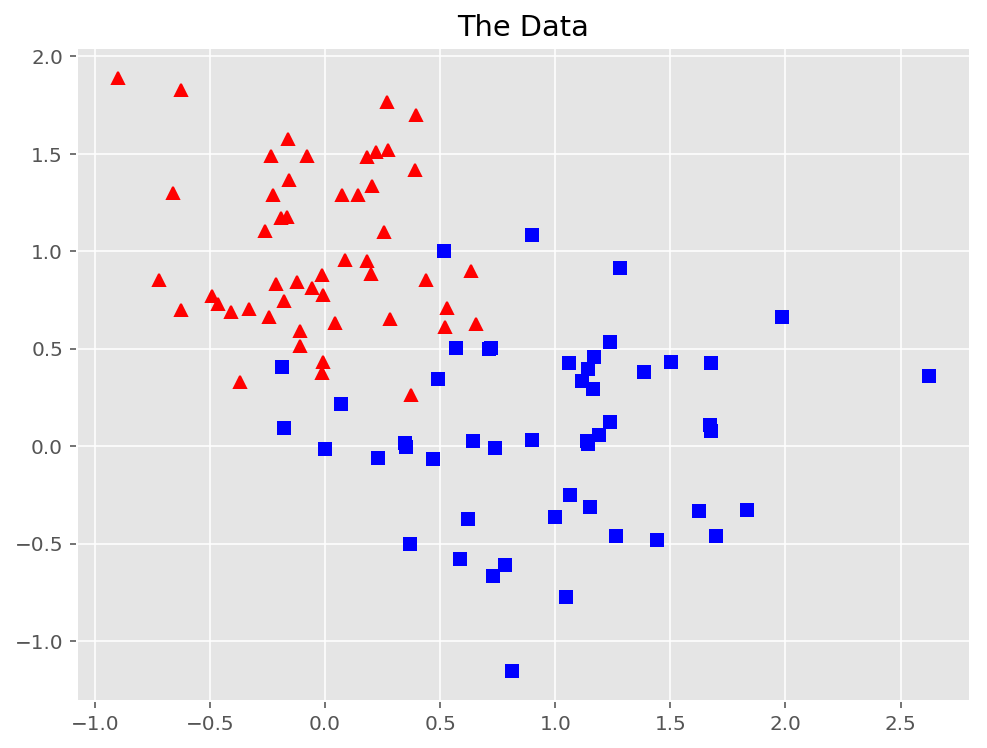

In [3]:
plt.figure(figsize=[8,6])
plt.plot(c1[:,0], c1[:,1], 'bs', label='a')
plt.plot(c2[:,0], c2[:,1], 'r^', label='b')
plt.title('The Data')
plt.show()

## Cross Validation in Scikit-learn
---
Scikit-learn has a function to perform cross validation:

In [4]:
from sklearn.model_selection import cross_val_score

We need to pass it a model object, the inputs of our data, and the targets of our data (in this case, our classes).

There are additional parameters to control various aspects of the cross-validation, which we'll explore; the most important one is the `cv` parameter which controls how folds are generated.

In [5]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C = 1)

scores = cross_val_score(model, data[['x', 'y']], data['class'],cv = 5)
scores.mean()

0.93

From the above, it appears that we can expect an accuracy of about 

In [6]:
scores.mean()

0.93

when using support vector classification on this problem.

It is also useful to think about the variance/standard deviation - how much variation will there be from run to run?

In [7]:
scores.std()

0.0678232998312527

## Benefits of (*k*-Fold) Cross Validation
---
- Better score estimates
  - All data gets in the test set (once)
  - All data gets in the training set (multiple times)
- Some information about sensitivity of the data to particular splits
- Can use more data in training (e.g., in 5-fold, use 80% of data for each training run)

## Stratification
---
How you choose folds matters!

- Naive approach just takes first k<sup>th</sup> data items as first fold, etc.
- In our example, naive approach would mean test set was all one class! 

Stratified *k*-fold cross validation:

- First k<sup>th</sup> of *each class*
- Ensures all classes (roughly) equally represented

Scikit-learn uses the stratified approach by default *if* the model is a classifier.


## Random Shuffling
---
- Another technique to use in generating folds
- Avoids training on only biased data, e.g., if data was not collected at random
- Can be turned on by using a customized `KFold` or `StratifiedKFold` object for the `cv` parameter:

In [8]:
from sklearn.model_selection import KFold, StratifiedKFold

scores = cross_val_score(model, data[['x', 'y']], 
                         data['class'], cv = StratifiedKFold(5, True))
print(scores)
print(scores.mean(),scores.std())


[0.95 1.   0.9  0.85 0.9 ]
0.9200000000000002 0.05099019513592784


## Shuffle-split Cross Validation
---
An alternative to *k*-fold cross validation:

- Randomly samples (without replacement) data points for training set
- Remaining points used as test set
- Allows size of split independent of number of training runs

In [9]:
from sklearn.model_selection import ShuffleSplit

scores = cross_val_score(model, data[['x', 'y']], 
                         data['class'], 
                         cv = ShuffleSplit(20, test_size = 0.2))
print(scores.mean(), scores.std())

0.9374999999999998 0.04710360920354193


## Parameter Search
---
Essentially, try different settings of parameters looking for "sweet spot".

Should not assume convexity, though!

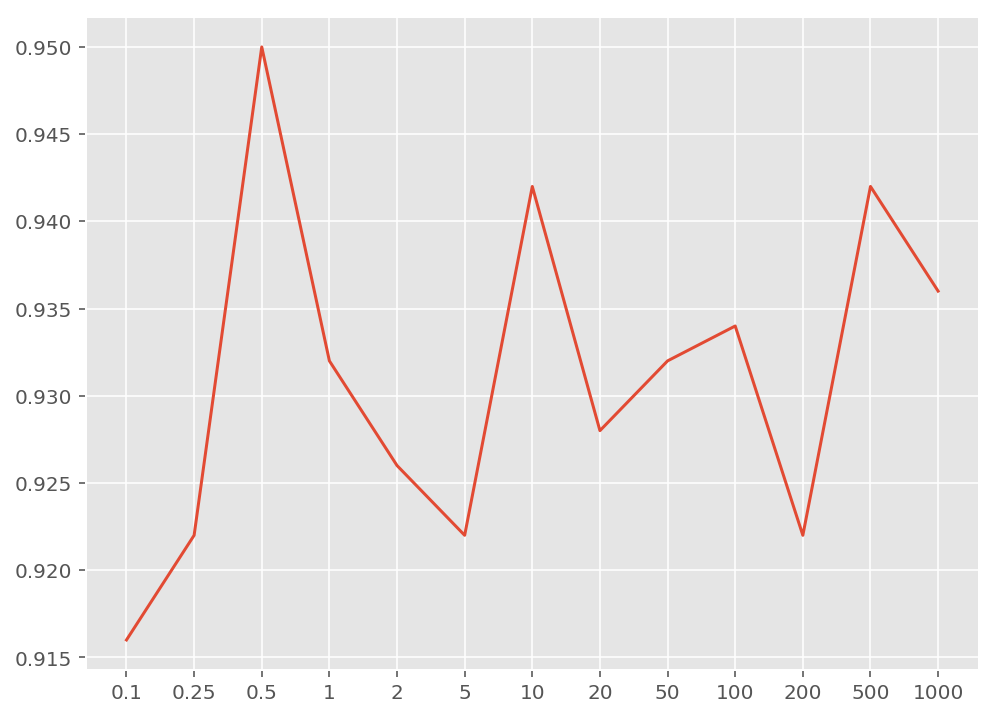

In [10]:
c_parms = [0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
#c_parms = [10, 12, 14, 16, 18, 20, 25, 30, 50, 100, 200, 300, 400, 500]
c_scores = []
for c in c_parms:
    model = SVC(kernel='linear', C=c)
    scores = cross_val_score(model, data[['x','y']], data['class'], 
                             cv = ShuffleSplit(50, test_size = 0.1))
    c_scores.append(scores.mean())

fig = plt.figure(figsize=[8,6])
plt.plot(range(len(c_parms)), c_scores)
fig.axes[0].set_xticks(range(len(c_parms)))
fig.axes[0].set_xticklabels(c_parms)
plt.show()

## Grid Search
---

- Tries all combination settings of parameters
- Obviously potentially very expensive
- Want to do iteratively: narrow in on a range of parameters, then search more finely within those

Another example, this time using RBFs - we now need to tune `gamma` as well as `C`:

In [11]:
c_parms = [0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
g_parms = [0.001, 0.01, 0.1, 1]
allscores = []
for c in c_parms:
    g_scores = []
    for g in g_parms:
        model = SVC(kernel='rbf', C=c, gamma=g)
        scores = cross_val_score(model, 
                                 data[['x','y']], data['class'], 
                                 cv = ShuffleSplit(20, test_size = 0.2))
        g_scores.append(scores.mean())
    allscores.append(g_scores)

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'colormap'
  s)


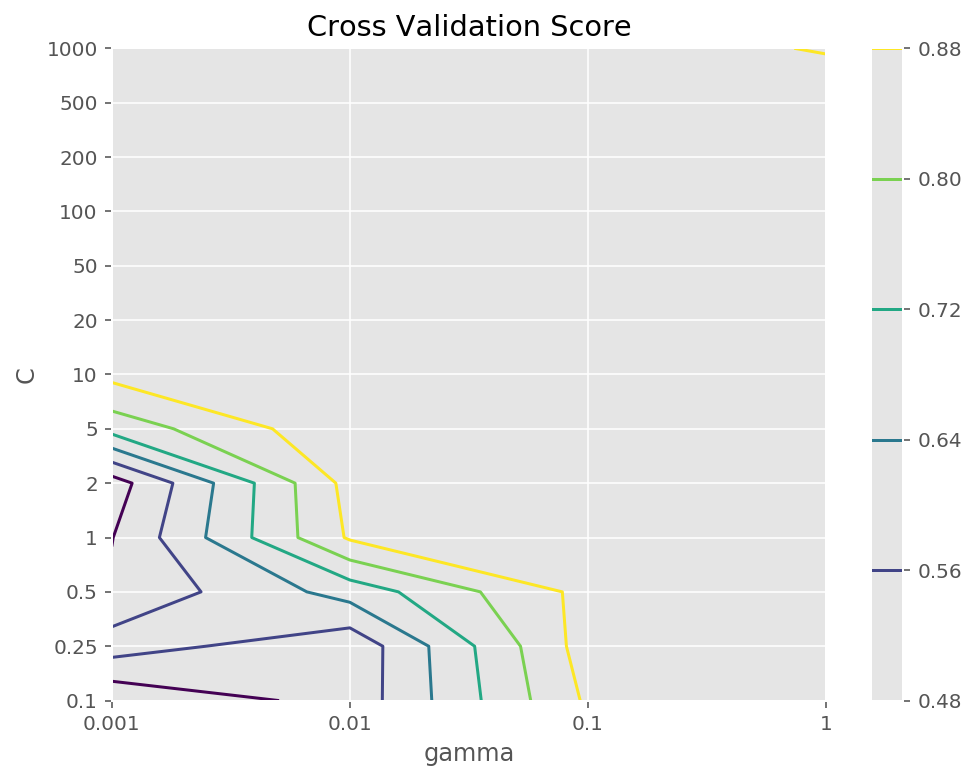

In [12]:
fig = plt.figure(figsize=[8,6])
plt.contour(range(len(g_parms)), range(len(c_parms)), 
            allscores, colormap='BuRd')
fig.axes[0].set_xticks(range(len(g_parms)))
fig.axes[0].set_xticklabels(g_parms)
plt.xlabel('gamma')
fig.axes[0].set_yticks(range(len(c_parms)))
fig.axes[0].set_yticklabels(c_parms)
plt.ylabel('C')
plt.colorbar()
plt.title('Cross Validation Score')
plt.show()

## Parameter Overfitting
---
We hit our best accuracy at about 0.94 using gamma = 0.1 and C = 200.

Can we claim our model is 94% accurate in general?

Again we have the potential for a kind of *overfitting* - this time, we did a parameter search which favored a particular set of data.

The solution is to add another layer of validation, by splitting our data further, this time into three groups.

We call these groups the training, validation, and test sets.

- training: train the model for fixed parameter setting
- validation: choose the parameters
- test: test for generalization

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.25)
c_parms = [0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
g_parms = [0.001, 0.01, 0.1, 1]
best = (0, 0)
bestscore = 0.0
for c in c_parms:
    g_scores = []
    for g in g_parms:
        model = SVC(kernel='rbf', C=c, gamma=g)
        scores = cross_val_score(model, train[['x','y']], train['class'], cv = 10)
        m = scores.mean()
        if m > bestscore:
            bestscore = m
            best = (c, g)

print('Training accuracy:', bestscore)
print('Parameters: C =', best[0], ', gamma =', best[1])

# Now, fit again using *all* of the training data, and evaluate on test data
model = SVC(kernel='rbf', C=best[0], gamma=best[1])
model.fit(train[['x','y']], train['class'])
print('Testing accuracy:', model.score(test[['x','y']], test['class']))



Training accuracy: 0.9464285714285715
Parameters: C = 500 , gamma = 0.1
Testing accuracy: 0.96


Note that this time we got very different settings for gamma and C, using less data for training!

This implies that our parameter search is very sensitive to the split in the data.

This is likely due to the relatively small amount of data we are working with.

## Grid Search with Cross Validation
---
Because the above operation is so common, scikit-learn has a function for it (of course).

Using the GridSearchCV function, you can do a search across a variety of parameters (even including things like different kernel types in SVC).

E.g.,

In [14]:
from sklearn.model_selection import GridSearchCV

parms = {'C': c_parms, 'gamma': g_parms}

model = GridSearchCV(SVC(), parms, cv=10)
model.fit(train[['x','y']], train['class'])
model.score(test[['x','y']], test['class'])

0.96

In [15]:
print('Training accuracy:', model.best_score_)
print('Best parameters:', model.best_params_)

Training accuracy: 0.9466666666666667
Best parameters: {'C': 500, 'gamma': 0.1}


## Next Time
---
We'll play with a classification dataset and see what we can discover!